In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


# EDA

In [4]:
df.duplicated(subset="user id").sum()

0

In [5]:
df.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [6]:
df_clean = df.drop(['Unnamed: 0', 'user id'], axis=1)
df_clean.head()

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


In [7]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [8]:
numeric_cols = df_clean.select_dtypes(include=[np.number])
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)

IQR = Q3 - Q1

# Outliers outside 1.5 * IQR raneg
outliers = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outliers

,total ads,most ads hour
0,True,False
1,True,False
2,False,False
3,True,False
4,True,False
...,...,...
588096,False,False
588097,False,False
588098,False,False
588099,False,False


In [9]:
df_outliers_clean = df_clean[~outliers.any(axis=1)]
df_outliers_clean.reset_index(drop=True, inplace=True)
df_outliers_clean

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,21,Tuesday,18
1,ad,False,17,Sunday,18
2,ad,False,21,Tuesday,19
3,ad,False,47,Wednesday,13
4,ad,False,61,Tuesday,20
...,...,...,...,...,...
530961,ad,False,1,Tuesday,23
530962,ad,False,1,Tuesday,23
530963,ad,False,3,Tuesday,23
530964,ad,False,1,Tuesday,23


#### Variable definition

In [10]:
continuous_var = ['total ads','most ads hour']
categorical_var = ['test group','converted','most ads day']

#### Frequency Table

In [79]:
def frequency_table(variable):
    unique_elements, counts=np.unique(variable.dropna(), return_counts=True)
    percentages = (counts/len(variable))*100
    value_counts_and_percentages = list(zip(unique_elements, counts, percentages))
    sorted_value_counts = sorted(value_counts_and_percentages, key=lambda x: x[2], reverse=True)

    for i,j,k in sorted_value_counts:
        print(f"{i}: Count {j}, Percentages: {k:.2f}%")
    return

for var in categorical_var:
    print(f"Frequency Table for {var}")
    print(frequency_table(df_outliers_clean[var]))
    print("Mode = ", df_outliers_clean[var].mode()[0])
    print("-"*50)

Frequency Table for test group
ad: Count 509847, Percentages: 96.02%
psa: Count 21119, Percentages: 3.98%
None
Mode =  ad
--------------------------------------------------
Frequency Table for converted
False: Count 523908, Percentages: 98.67%
True: Count 7058, Percentages: 1.33%
None
Mode =  False
--------------------------------------------------
Frequency Table for most ads day
Friday: Count 82874, Percentages: 15.61%
Monday: Count 78268, Percentages: 14.74%
Sunday: Count 77147, Percentages: 14.53%
Thursday: Count 75651, Percentages: 14.25%
Saturday: Count 73734, Percentages: 13.89%
Wednesday: Count 73099, Percentages: 13.77%
Tuesday: Count 70193, Percentages: 13.22%
None
Mode =  Friday
--------------------------------------------------


- Skewness indicates the distribution's asymmetry
- Kurtosis indicates peakedness 


In [97]:
concatenated_series = pd.concat([
    df_outliers_clean[continuous_var].describe().T,
    df_outliers_clean[continuous_var].skew().rename('skewness'),
    df_outliers_clean[continuous_var].kurtosis().rename('kurtosis')
], axis=1)


# Adding lower and upper confidence intervals
confidence_level = 0.95  # 95% confidence interval

for var in continuous_var:
    values = df_outliers_clean[var].dropna()
    mean = values.mean()
    std_error = stats.sem(values)
    if std_error != 0:
        lower, upper = stats.t.interval(confidence_level, len(values) - 1, loc=mean, scale=std_error)
    else:
        lower, upper = mean, mean

    # Adding lower and upper confidence intervals to the concatenated series
    concatenated_series.loc[var, 'lower_ci'] = lower
    concatenated_series.loc[var, 'upper_ci'] = upper
concatenated_series

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,lower_ci,upper_ci
total ads,530966.0,15.143169,14.062835,1.0,4.0,11.0,22.0,61.0,1.205645,0.824961,15.105343,15.180995
most ads hour,530966.0,14.613625,4.644968,1.0,11.0,14.0,18.0,23.0,-0.181918,-0.200956,14.601131,14.626119


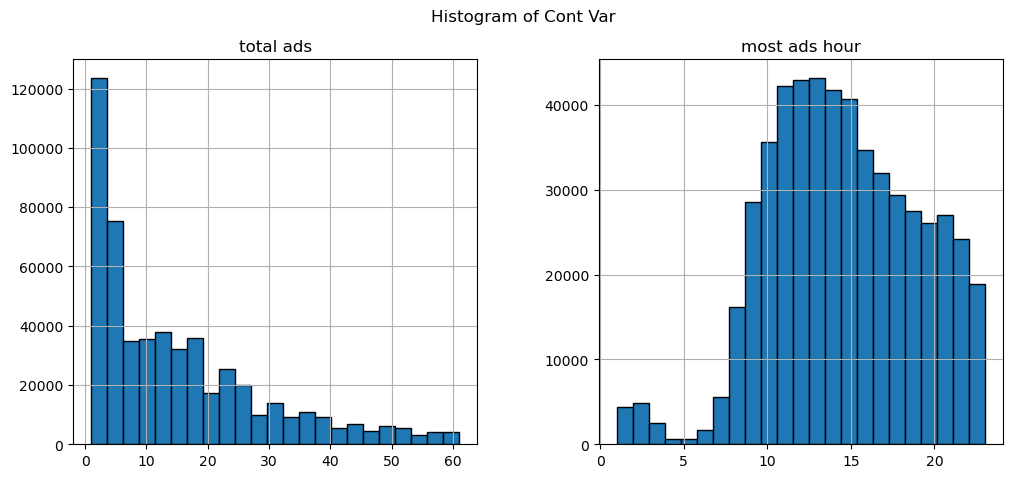

In [94]:
import matplotlib.pyplot as plt

df_outliers_clean[continuous_var].hist(bins=23, figsize=(12, 5), edgecolor='black')
plt.suptitle("Histogram of Cont Var")
plt.show()

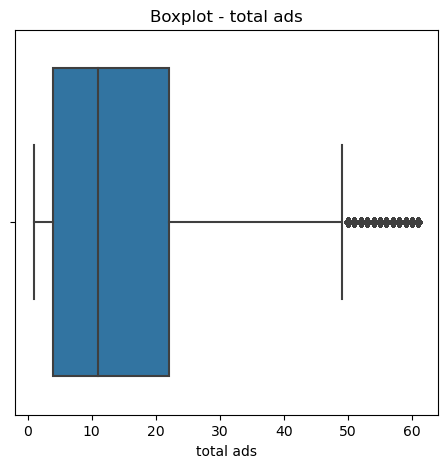

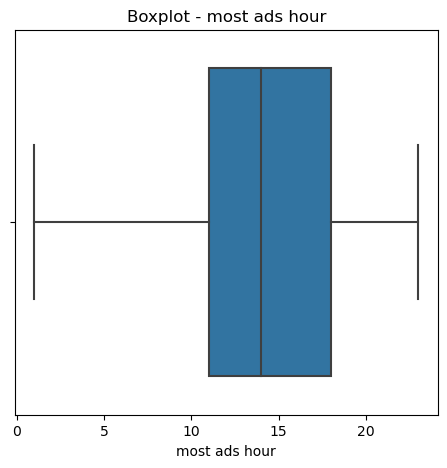

In [103]:
import seaborn as sns


for variable in continuous_var:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=variable, data=df_outliers_clean)
    plt.title(f'Boxplot - {variable}')

# Chi-square Test for independence


## Most ads day

In [134]:
#Let us make our contingency table first

ct = pd.crosstab(df_outliers_clean['converted'],df_outliers_clean['most ads day'] )
print("Contingency Table with Frequencies:")
display(ct)
print("-"*50)

# Row Percentage
row_percentages = ct.div(ct.sum(axis=1), axis=0) * 100
print("Contingency Table with Row Percentages:")
display(row_percentages)
print("-"*50)   

# Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(ct)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("-"*50)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100
print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("-"*50)
#If there are cells with expected counts less than 5, it indicates that there are not enough observations to reliably estimate the statistical significance of the association between the variables.
#This can lead to a higher likelihood of Type I errors (incorrectly rejecting the null hypothesis) or Type II errors (failing to reject the null hypothesis when it should be rejected).

# Residuals: Calculates the magnitude and direction of the strength of association
# Interpretation:
# Positive Residuals: A positive value indicates that the observed count is higher than the expected count. This suggests that there may be a stronger association than expected between the categories.
# Negative Residuals: A negative value indicates that the observed count is lower than the expected count. This suggests a weaker association than expected.
residuals = ct - expected
print("Residuals:")
display(residuals)
print("-"*50)

# Calculate Cramér's V
n = ct.sum().sum()  # Total number of observations
min_dim = min(ct.shape) - 1  # Minimum dimension minus 1
cramers_v = np.sqrt(chi2 / (n * min_dim))  # Cramér's V calculation
print(f"Cramér's V: {cramers_v}")

Contingency Table with Frequencies:


most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
False,81899,76905,72946,76134,74779,69096,72149
True,975,1363,788,1013,872,1097,950


--------------------------------------------------
Contingency Table with Row Percentages:


most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
False,15.632325,14.679104,13.923437,14.531941,14.273308,13.188575,13.771311
True,13.814112,19.311420,11.164636,14.352508,12.354775,15.542647,13.459904


--------------------------------------------------
Chi2: 202.12793298243886
P-value: 6.687035227949662e-41
Degrees of Freedom: 6
--------------------------------------------------
Percentage of cells with expected counts less than 5: 0.00%
--------------------------------------------------
Residuals:


most ads day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
converted,,,,,,,
False,126.623629,-322.602792,192.127865,12.496032,133.610073,-163.941774,21.686967
True,-126.623629,322.602792,-192.127865,-12.496032,-133.610073,163.941774,-21.686967


--------------------------------------------------
Cramér's V: 0.019511012684828473


Interpretation:<br>
<div>
1. Contingency Table:
<li> This table shows count of conversion and non-conversion based on the most frequent day users saw ads.</li><br>
2. Row Percentages:
<li> Monday has the highest proportion of conversions (19.31%), while Saturday has the lowest (11.16%). Whereas, Friday has the highest non-conversion of (15.6%) while Tuesday has the lowers of (13.18%)</li><br>
3. Chi-Squared Test:
<li>Chi2: 202.12793298243886
<li>P-value: 6.687035227949662e-41
<li>Degrees of Freedom: 6
<li> Low p-value, lesser than 0.05 signifies a statistical significant association between the day users saw ads and their conversion status.</li><br>
4. Residuals:
<li>Positive residuals mean that the actual count is higher than the expected count, and negative residuals mean the actual count is lower than expected.</li><br>
<li>For example:</li>
<li>Monday (True): The positive residual (322.6) means more people converted on Monday than expected.
<li>Saturday (True): The negative residual (-192.12) indicates fewer people converted on Saturday than expected.</li><br>
5. Conclusion
<li>There is association between the day users see the ads and their conversion likelihood. However, cramer's V suggest that this association is relatively weak.
<li>Users seeing ads most frequently on Monday tend to convert more, while Saturday seems to have the least conversion.
</div>

## Most ads hour

In [118]:
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:   
        return 'Night'
    
df_outliers_clean['time_slot'] = df_outliers_clean['most ads hour'].apply(categorize_hour)
df_outliers_clean

,test group,converted,total ads,most ads day,most ads hour,time_slot
0,ad,False,21,Tuesday,18,Evening
1,ad,False,17,Sunday,18,Evening
2,ad,False,21,Tuesday,19,Evening
3,ad,False,47,Wednesday,13,Afternoon
4,ad,False,61,Tuesday,20,Evening
...,...,...,...,...,...,...
530961,ad,False,1,Tuesday,23,Night
530962,ad,False,1,Tuesday,23,Night
530963,ad,False,3,Tuesday,23,Night
530964,ad,False,1,Tuesday,23,Night


In [133]:
#Let us make our contingency table first

ct = pd.crosstab(df_outliers_clean['converted'],df_outliers_clean['time_slot'] )
print("Contingency Table with Frequencies:")
display(ct)
print("-"*50)

# Row Percentage
row_percentages = ct.div(ct.sum(axis=1), axis=0) * 100
print("Contingency Table with Row Percentages:")
display(row_percentages)
print("-"*50)   

# Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(ct)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("-"*50)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100
print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("-"*50)
#If there are cells with expected counts less than 5, it indicates that there are not enough observations to reliably estimate the statistical significance of the association between the variables.
#This can lead to a higher likelihood of Type I errors (incorrectly rejecting the null hypothesis) or Type II errors (failing to reject the null hypothesis when it should be rejected).

# Residuals: Calculates the magnitude and direction of the strength of association
# Interpretation:
# Positive Residuals: A positive value indicates that the observed count is higher than the expected count. This suggests that there may be a stronger association than expected between the categories.
# Negative Residuals: A negative value indicates that the observed count is lower than the expected count. This suggests a weaker association than expected.
residuals = ct - expected
print("Residuals:")
display(residuals)
print("-"*50)

# Calculate Cramér's V
n = ct.sum().sum()  # Total number of observations
min_dim = min(ct.shape) - 1  # Minimum dimension minus 1
cramers_v = np.sqrt(chi2 / (n * min_dim))  # Cramér's V calculation
print(f"Cramér's V: {cramers_v}")

Contingency Table with Frequencies:


time_slot,Afternoon,Evening,Morning,Night
converted,,,,
False,200437,113204,128902,81365
True,2871,1695,1391,1101


--------------------------------------------------
Contingency Table with Row Percentages:


time_slot,Afternoon,Evening,Morning,Night
converted,,,,
False,38.258053,21.607610,24.603938,15.530398
True,40.677246,24.015302,19.708133,15.599320


--------------------------------------------------
Chi2: 97.34617134565939
P-value: 5.781513197287742e-21
Degrees of Freedom: 3
--------------------------------------------------
Percentage of cells with expected counts less than 5: 0.00%
--------------------------------------------------
Residuals:


time_slot,Afternoon,Evening,Morning,Night
converted,,,,
False,-168.476931,-167.675949,340.952694,-4.799814
True,168.476931,167.675949,-340.952694,4.799814


--------------------------------------------------
Cramér's V: 0.013540231246510952


Conclusion
<li>There is a association between the time slot and the conversion likelihood. However, cramer's V suggest that this association is relatively weak.
<li> Users tend to convert at afternoon than night, and they don't convert more at afternoon and at night as well.
<li> Lastly, users convert at evening more than expected whereas user does not convert more than expected at morning.
<li> <b>Afternoon</b> seems to be the most effective timeslot for conversion, while the <b>Morning</b> shows more non-conversion than expected.

## Test group

In [135]:
#Let us make our contingency table first

ct = pd.crosstab(df_outliers_clean['converted'],df_outliers_clean['test group'] )
print("Contingency Table with Frequencies:")
display(ct)
print("-"*50)

# Row Percentage
row_percentages = ct.div(ct.sum(axis=1), axis=0) * 100
print("Contingency Table with Row Percentages:")
display(row_percentages)
print("-"*50)   

# Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(ct)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("-"*50)

# Calculate the percentage of cells with expected counts less than 5
percentage_low_expected = (expected < 5).sum().sum() / (expected.shape[0] * expected.shape[1]) * 100
print(f"Percentage of cells with expected counts less than 5: {percentage_low_expected:.2f}%")
print("-"*50)
#If there are cells with expected counts less than 5, it indicates that there are not enough observations to reliably estimate the statistical significance of the association between the variables.
#This can lead to a higher likelihood of Type I errors (incorrectly rejecting the null hypothesis) or Type II errors (failing to reject the null hypothesis when it should be rejected).

# Residuals: Calculates the magnitude and direction of the strength of association
# Interpretation:
# Positive Residuals: A positive value indicates that the observed count is higher than the expected count. This suggests that there may be a stronger association than expected between the categories.
# Negative Residuals: A negative value indicates that the observed count is lower than the expected count. This suggests a weaker association than expected.
residuals = ct - expected
print("Residuals:")
display(residuals)
print("-"*50)

# Calculate Cramér's V
n = ct.sum().sum()  # Total number of observations
min_dim = min(ct.shape) - 1  # Minimum dimension minus 1
cramers_v = np.sqrt(chi2 / (n * min_dim))  # Cramér's V calculation
print(f"Cramér's V: {cramers_v}")

Contingency Table with Frequencies:


test group,ad,psa
converted,,
False,503015,20893
True,6832,226


--------------------------------------------------
Contingency Table with Row Percentages:


test group,ad,psa
converted,,
False,96.012086,3.987914
True,96.797960,3.202040


--------------------------------------------------
Chi2: 11.056659044570122
P-value: 0.0008836923618084476
Degrees of Freedom: 1
--------------------------------------------------
Percentage of cells with expected counts less than 5: 0.00%
--------------------------------------------------
Residuals:


test group,ad,psa
converted,,
False,-54.729655,54.729655
True,54.729655,-54.729655


--------------------------------------------------
Cramér's V: 0.004563295602894607


Conclusion
<li>There is a association between the test group and the conversion likelihood. However, cramer's V suggest that this association is extremely weak.
<li> user tends to convert more when looking at ads than psa
<li> psa is underperforming than ads when comes to conversion rate

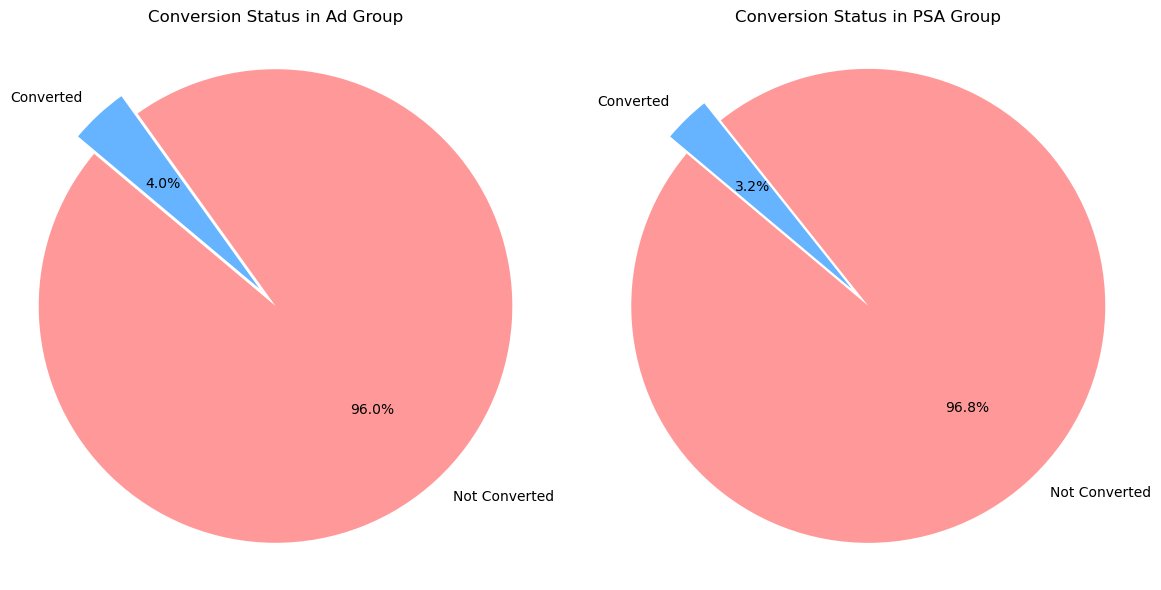

In [137]:
import matplotlib.pyplot as plt

# Data for 'ad' and 'psa' groups
labels = ['Not Converted', 'Converted']
sizes_ad = [503015,20893]  # False, True counts for 'ad'
sizes_psa = [6832,226]    # False, True counts for 'psa']
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Not Converted)

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for 'ad' group
axes[0].pie(sizes_ad, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Conversion Status in Ad Group')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Pie chart for 'psa' group
axes[1].pie(sizes_psa, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Conversion Status in PSA Group')
axes[1].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Display both pie charts
plt.tight_layout()
plt.show()

In [141]:
from scipy.stats import ttest_ind, shapiro, levene,mannwhitneyu

# Assuming df_outliers_clean is already defined

# Create a new DataFrame to store conversion counts by day
shapiro_stat_true, shapiro_p_value_true = shapiro(df_outliers_clean[df_outliers_clean['converted']==1]['total ads'])
shapiro_stat_false, shapiro_p_value_false = shapiro(df_outliers_clean[df_outliers_clean['converted']==0]['total ads'])
print(f"shapiro-wilk test for normality (True group): p-value={shapiro_p_value_true}")
print(f"shapiro-wilk test for normality (False group): p-value={shapiro_p_value_false}")

levene_stat, levene_p_value = levene(df_outliers_clean[df_outliers_clean['converted']]['total ads'], df_outliers_clean[~df_outliers_clean['converted']]['total ads'])
print(f"Levene test statistics{levene_stat}")
print(f"Levene test for equality of variances: p-value={levene_p_value}")
print("-"*100)

if shapiro_p_value_true > 0.05 and shapiro_p_value_false > 0.05:
    print("The data is normally distributed")
else:
    print("The data is not normally distributed")

if levene_p_value < 0.05:
    print("The variance is not equal")
else:
    print("The variance is equal")

shapiro-wilk test for normality (True group): p-value=2.8063383955493814e-40
shapiro-wilk test for normality (False group): p-value=0.0
Levene test statistics1198.8288633975717
Levene test for equality of variances: p-value=2.1565038632220888e-262
----------------------------------------------------------------------------------------------------
The data is not normally distributed
The variance is not equal


In [148]:
u_stat, u_p_value = mannwhitneyu(df_outliers_clean[df_outliers_clean['converted']]['total ads'], df_outliers_clean[~df_outliers_clean['converted']]['total ads'])
print(f"Man-whitney U test: U-statistics={u_stat}")
print(f"Mann-whitney U test: p-value ={u_p_value}")

Man-whitney U test: U-statistics=2942795128.5
Mann-whitney U test: p-value =0.0


In [147]:
# Calculate effect size for Mann-Whitney U test
n1 = len(df_outliers_clean[df_outliers_clean['converted']]['total ads'])
n2 = len(df_outliers_clean[~df_outliers_clean['converted']]['total ads'])
u = u_stat
rank_biserial = 1 - (2 * u) / (n1 * n2)
print(f"Rank-biserial correlation (effect size) = {rank_biserial}")

Rank-biserial correlation (effect size) = -0.5916711333917746


Strong inverse relationship between conversion and total ads: users who did not convert saw more ads than those who converted.

## A/B Test the equality of proportions hypothesis: psa and ads

In [155]:
cross_tab = pd.crosstab(df_outliers_clean['test group'],df_outliers_clean['converted'], normalize='index')
cross_tab

converted,False,True
test group,,
ad,0.986600,0.013400
psa,0.989299,0.010701


<b> Define null and alternative hypothesis
- H0: there is no difference in the conversion rate between the test groups
- H1: there is a difference in the version rates between the test group and the control group

<b> Set the probability of type I and type II errors </b>
<li> we set : a = 0.05 and b = 0.2 </li>

<b> Calculate the sample size </b>
<br>
Based on the provided conversion data, we have the conversion rates for two groups in an A/B test: one group that saw the advertisement ("ad") and another that saw a public service announcement ("psa"). The conversion rates are calculated as follows:
<br>
<b>Ad group: conversion rate: 1.34%</b>
<br>
<b>PSA group: conversion rate: 1.07%</b>

Let us find our required sample size:

In [27]:
from statsmodels.stats.power import NormalIndPower

# Parameters
alpha = 0.05  # Significance level
power = 0.8   # Power (1-b)
p1 = 0.010701  # Conversion rate for control group (psa)
p2 = 0.013400  # Conversion rate for test group (ad)

# Calculate the average conversion rate
p = (p1 + p2) / 2

# Calculate the effect size
effect_size = (p2 - p1) / ((p * (1 - p)) ** 0.5)

# Calculate the sample size per group
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)

print(f"Required sample size per group: {int(sample_size)}")

available_population = len(df_outliers_clean)

if sample_size > available_population:
    print("Warning: Required sample size exceeds available population size.")
    
    # Apply Finite Population Correction (FPC)
    n_adjusted = sample_size * (available_population - 1) / (sample_size + available_population - 1)
    print(f"Adjusted sample size per group (FPC applied): {int(n_adjusted)}")
else:
    print("The required sample size is within the available population size.")

Required sample size per group: 25654
The required sample size is within the available population size.


Choose samples

In [26]:
def choose_random_sample(data, sample_size, random_state=42):
    # Check the size of the group
    group_size = len(data)

    # Set sample size to the minimum of requested sample size and group size
    adjusted_sample_size = min(int(sample_size), group_size)

    return data.sample(n=adjusted_sample_size, random_state=random_state)

# Apply the function to each group using groupby
df_smpl = df_outliers_clean.groupby('test group', group_keys=False).apply(lambda x: choose_random_sample(x, sample_size))

df_psa= df_smpl[df_smpl['test group'] == 'psa']
df_ad= df_smpl[df_smpl['test group'] == 'ad']
print(f"psa sample size: {df_psa.shape}")
print(f"ad sample size: {df_ad.shape}")

psa sample size: (21119, 5)
ad sample size: (25654, 5)


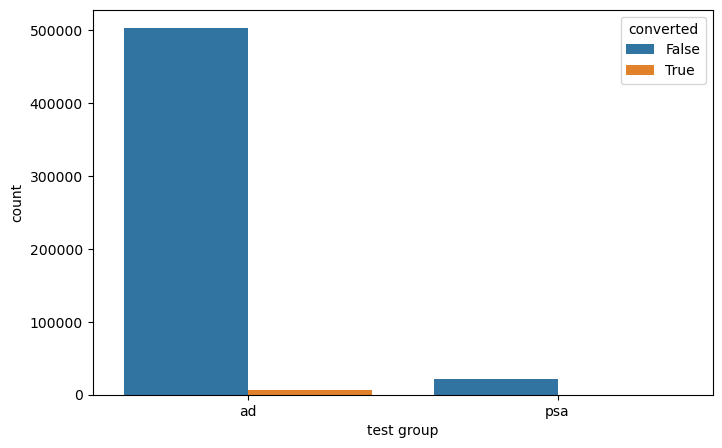

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.countplot(data=df_outliers_clean, x='test group', hue='converted', ax=ax)

plt.show()

In [15]:
import pandas as pd
import statsmodels.api as sm

# Create the contingency table
contingency_table_Z = pd.crosstab(df_smpl['test group'], df_smpl['converted'])


print("Contingency Table with Frequencies:")
print(contingency_table_Z)
print("#"*60)

# Calculate row percentages
row_percentages = contingency_table_Z.div(contingency_table_Z.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
print(row_percentages)
print("#"*60) 

# Count the number of successes and trials in each group
success_ad = contingency_table_Z.loc['ad', True]
trials_ad = contingency_table_Z.loc['ad', False] + contingency_table_Z.loc['ad', True]

success_psa = contingency_table_Z.loc['psa', True]
trials_psa = contingency_table_Z.loc['psa', False] + contingency_table_Z.loc['psa', True]

# Perform the z-test for proportions
#two-sample z test
#o compare the specific success rates (conversion rates) of two groups
z_stat, p_value = sm.stats.proportions_ztest(
    [success_ad, success_psa], 
    [trials_ad, trials_psa], 
    alternative='larger'
)

# Print the results
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in proportions.")
else:
    print("Fail to reject the null hypothesis. Proportions are not significantly different.")

Contingency Table with Frequencies:
converted   False  True
test group             
ad          25315   339
psa         20893   226
############################################################

Row Percentages:
converted       False      True
test group                     
ad          98.678569  1.321431
psa         98.929874  1.070126
############################################################
Z-statistic: 2.4758825048245057
P-value: 0.006645365441133906
Reject the null hypothesis. There is a significant difference in proportions.


- A higher Z-statistic (positive) suggests that the first group (success_ad) has a higher proportion compared to the second group (success_psa).
- This indicates that there is a statistically significant difference in the proportions of conversions between the ad group and the PSA group. The difference in the proportions is not due to random chance.

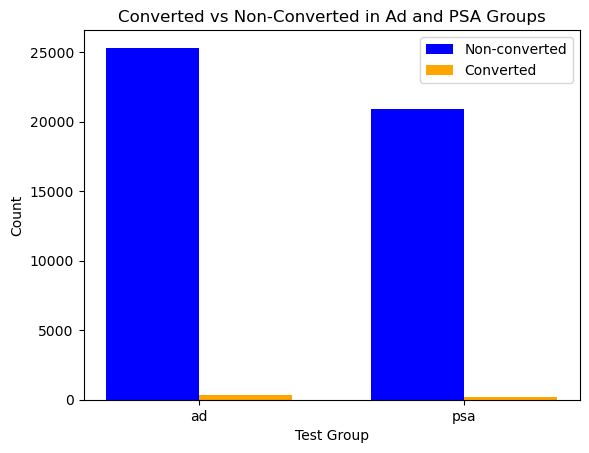

In [196]:
# Data from the contingency table
groups = ['ad', 'psa']
false_values = [25315, 20893]
true_values = [339, 226]

# Plot a grouped bar chart
bar_width = 0.35
index = range(len(groups))

plt.bar(index, false_values, bar_width, label='Non-converted', color='blue')
plt.bar([i + bar_width for i in index], true_values, bar_width, label='Converted', color='orange')

plt.xlabel('Test Group')
plt.ylabel('Count')
plt.title('Converted vs Non-Converted in Ad and PSA Groups')
plt.xticks([i + bar_width / 2 for i in index], groups)
plt.legend()
plt.show()

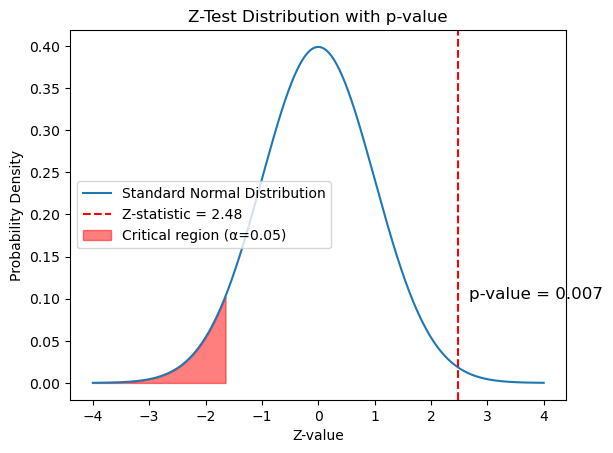

In [197]:
# Z-statistic and p-value (from your z-test result)
z_stat = 2.4758825048245057
p_value = 0.006645365441133906  # From your z-test result
alpha = 0.05

# Generate data for normal distribution
z_values = np.linspace(-4, 4, 1000)
y_values = stats.norm.pdf(z_values)

# Plot the z-distribution
plt.plot(z_values, y_values, label='Standard Normal Distribution')
plt.axvline(z_stat, color='red', linestyle='--', label=f'Z-statistic = {z_stat:.2f}')
plt.fill_between(z_values, y_values, where=(z_values < stats.norm.ppf(alpha)), color='red', alpha=0.5, label=f'Critical region (α={alpha})')

# Add the p-value as text on the plot
plt.text(z_stat + 0.2, 0.1, f'p-value = {p_value:.3f}', color='black', fontsize=12)

plt.title('Z-Test Distribution with p-value')
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [202]:
contingency_table_Z

converted,False,True
test group,,
ad,25315,339
psa,20893,226


Odds ratio compares the odds of success between two groups.

In [199]:
def OR_CIs(contingency_table):
    
    # Calculate odds ratio
    odds_ratio = (contingency_table.iloc[0, 0] / contingency_table.iloc[0, 1]) / (contingency_table.iloc[1, 0] / contingency_table.iloc[1, 1])

    # Calculate standard error of log(odds ratio)
    log_odds_std_error = np.sqrt(contingency_table.applymap(lambda x: 1/x).sum().sum())

    # Set confidence level
    confidence_level = 0.95

    # Calculate z-score for the confidence interval
    z_score = norm.ppf(1-(1 - confidence_level) / 2)

    # Calculate confidence intervals
    ci_low = np.exp(np.log(odds_ratio) - z_score * log_odds_std_error)
    ci_high = np.exp(np.log(odds_ratio) + z_score * log_odds_std_error)
    
    # Print the results
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"95% Confidence Interval: {ci_low:.2f}, {ci_high:.2f}")
    
    return
# Calculate the confidence interval for odds ratio
OR_CIs(contingency_table_Z)

Odds Ratio: 0.81
95% Confidence Interval: 0.68, 0.96


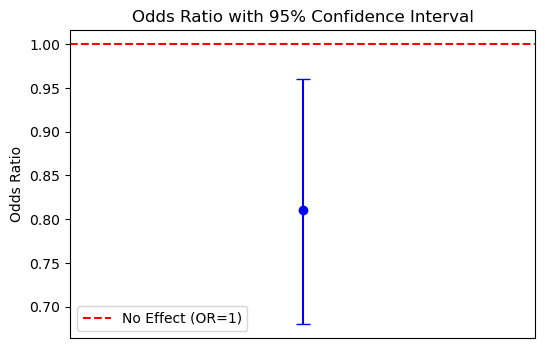

In [203]:
odds_ratio = 0.81  # This is a placeholder value
conf_int = [0.68, 0.96]  # Confidence interval for the odds ratio

plt.figure(figsize=(6, 4))
plt.errorbar(1, odds_ratio, yerr=[[odds_ratio - conf_int[0]], [conf_int[1] - odds_ratio]], fmt='o', capsize=5, color='blue')
plt.axhline(1, linestyle='--', color='red', label='No Effect (OR=1)')
plt.title('Odds Ratio with 95% Confidence Interval')
plt.ylabel('Odds Ratio')
plt.xlim(0.5, 1.5)
plt.xticks([])
plt.legend()
plt.show()

<b> Overall Interpretation: </b>
<li> There is a statistical significant difference in conversion rates between the ad and psa groups.
<li> The conversion rate in ad group is slightly higher than in the PSA group, however the odds ratio suggest that the users exposed to ad have a lower odds of converting than those exposed to PSA.
<li> While the ad group had a higher conversion percentage, the odds ratio indicates that users in the PSA group had a better relative chance of converting compared to the ad group, when accounting for odds rather than raw proportions.